In [7]:
import torch
import numpy as np
from diffusers.training_utils import compute_snr
from diffusers import DDPMScheduler
import pickle
from piq import LPIPS
from torch.optim import AdamW
import torch.nn.functional as F
import sys
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import make_grid

sys.path.append("edm")
from edm.torch_utils import misc
from edm.dnnlib import util
from edm.training.networks import EDMPrecond
from edm import generate

DEVICE = torch.device("cuda")
NUM_CLASSES = 10

In [ ]:
with open("edm-cifar10-32x32-cond-ve.pkl", 'rb') as f:
    mu_real = pickle.load(f)['ema'].train().to(DEVICE)
mu_real.eval()
print()

In [3]:
BATCH_SIZE = 64
T = 100
const_timestep_G = torch.tensor([100] * BATCH_SIZE, device=DEVICE)

In [4]:
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

In [12]:
noise_dataset = []
class_labels_dataset = []
y_dataset = []

In [14]:
from tqdm import tqdm
for class_label in tqdm(range(NUM_CLASSES)):
    class_labels = torch.zeros(BATCH_SIZE, NUM_CLASSES, device=DEVICE)
    class_labels[np.arange(BATCH_SIZE), [class_label] * BATCH_SIZE] = 1
    for _ in range(4):
        z = torch.randn(BATCH_SIZE, 3, 32, 32, device=DEVICE)
        with torch.no_grad():
            y = generate.ablation_sampler(mu_real, z, class_labels, num_steps=64, schedule="ve", scaling="none", discretization="ve", solver="heun")
        noise_dataset.append(z.detach().cpu().clone())
        class_labels_dataset.append(class_labels.detach().cpu().clone())
        y_dataset.append(y.detach().cpu().clone())

100%|██████████| 10/10 [34:29<00:00, 206.93s/it]


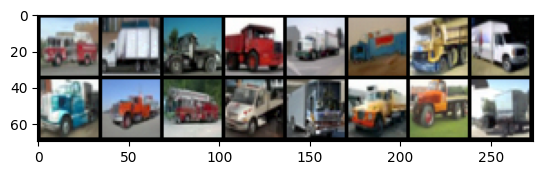

In [15]:
plt.imshow(make_grid((normalize(y_dataset[-1])[:16] + 1) / 2).cpu().permute(1, 2, 0).detach().numpy())

In [19]:
torch.cat(y_dataset).shape

torch.Size([2560, 3, 32, 32])

In [20]:
torch.save(torch.cat(noise_dataset), "dataset/noise.pt")
torch.save(torch.cat(class_labels_dataset), "dataset/class_labels.pt")
torch.save(torch.cat(y_dataset), "dataset/y.pt")
